# Initial imports and definitions

In [4]:
import zipfile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import geopy.distance
from matplotlib import cm
from io import StringIO
import json

In [5]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def plot_dendrogram(model, plot=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    order = dendrogram(linkage_matrix, no_plot = not plot, get_leaves=True, **kwargs)['leaves']
    return linkage_matrix, order


def elbow(data):
    elbowdata = np.array(data)
    if elbowdata.shape[1] != 2:
        elbowdata = elbowdata.T
    elbowdata -= elbowdata[0]
    rotation = np.linalg.inv(np.vstack([elbowdata[-1], [-elbowdata[-1,1], elbowdata[-1,0]]]).T)
    idx = np.argmin((elbowdata @rotation.T)[:,1])
    return idx    


def autocluster(data, return_order=False, return_linkage=False, plot=False, **kwargs):
    ag = AgglomerativeClustering(distance_threshold=0,n_clusters=None,**kwargs)
    ag.fit(data)
    linkage_matrix, order = plot_dendrogram(ag)
    idx = len(linkage_matrix) - elbow(list(enumerate(linkage_matrix[:,2])))
    if plot:
        plt.plot(linkage_matrix[:,2][::-1])
        plt.show()
    print("number of clusters: ", idx)
    ag2 = AgglomerativeClustering(n_clusters=idx, **kwargs)
    ag2.fit(data)
    ret = [ag2]
    if return_order:
        ret.append(order)
    if return_linkage:
        ret.append(linkage_matrix)
    return tuple(ret) if len(ret) > 1 else ret[0]

In [6]:
def plot_abq(data, first=True, **kwargs):
    if first:
        print('loading image')
        img = Image.open('abqmap2.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
    for row in data:
        if 'latitude' in row:
            plot(row['latitude'], row['longitude'], **kwargs)
        else:
            plot(*row, **kwargs)
def plot(lat,lon,c, **kwargs):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c, **kwargs)

# right, need to convert lat/lon to euclidean
origin_x = -106.544256
origin_y = 35.034674
foot_x = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_x *= 0.9
    else:
        foot_x *= 1.05
        
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y, origin_x + foot_x)).feet
foot_y = 1
d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
while abs(d-1) > 1e-5:
    if d > 1:
        foot_y *= 0.9
    else:
        foot_y *= 1.05
    d = geopy.distance.geodesic( (origin_y, origin_x), (origin_y+foot_y, origin_x)).feet
    

def ll2euclid(ptx, pty):
    pt = np.array([ptx, pty])
    pt -= [origin_y, origin_x]
    pt /= [foot_y, foot_x]
    return pt

In [7]:
def trip2array(trip, n):
    locations = np.zeros((n,2))
    msg_times = np.array([str2time(t) for t in trip['msg_time']])
    for i,t in zip(range(n), np.linspace(min(msg_times),max(msg_times),n, endpoint=False)):
        x = np.argmax(msg_times > t)
        locations[i] = ((trip['latitude'].iloc[x] + trip['latitude'].iloc[x-1])/2, (trip['longitude'].iloc[x] + trip['longitude'].iloc[x-1])/2)
    return locations

def str2time(s):
    hour,minute,second = list(map(int,s.split(':')))
    return second + 60*minute + 60*60*hour

with open('stoplocations.json') as file:
    stoplocations = json.load(file)
    
with open('stopnames.json') as file:
    stopnames = json.load(file)

# The analysis

In [8]:
full_days = '10_11 10_10 10_8 10_9 9_28 9_23 9_21 9_22 9_12 10_7 9_19 9_16 9_17 9_18'.split()
all_arts = []
for day in tqdm(full_days):
    with zipfile.ZipFile('../busdata/bus.zip') as file:
        with file.open(f'bus_data_2022_{day}.csv') as myfile:
            data = myfile.read()
    

    df = pd.read_csv(StringIO(data.decode()))
    arts = df[df.route_short_name=='777']
    for id in set(arts.trip_id):
        all_arts.append(arts[arts.trip_id == id])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.25s/it]


In [9]:
len(all_arts)

1450

In [10]:
trip_arrays = []
for art in tqdm(all_arts):
        trip = art.sort_values('msg_time', key=lambda x: [str2time(y) for y in x])
        trip_arrays.append(trip2array(trip,100))
trip_arrays = np.array(trip_arrays)

100%|█████████████████████████████████████████████████████████████████████████████| 1450/1450 [00:05<00:00, 275.87it/s]


C:\Users\patri\anaconda3\envs\jupyter\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


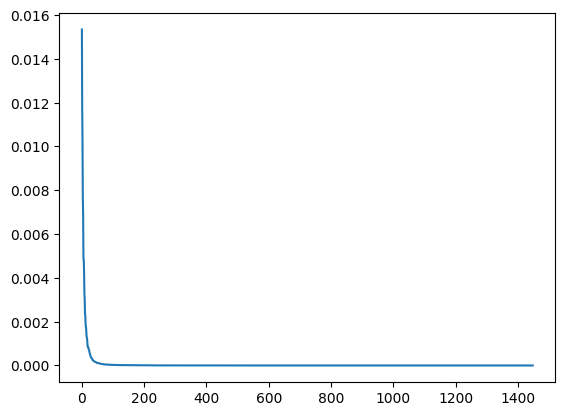

C:\Users\patri\anaconda3\envs\jupyter\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


number of clusters:  40


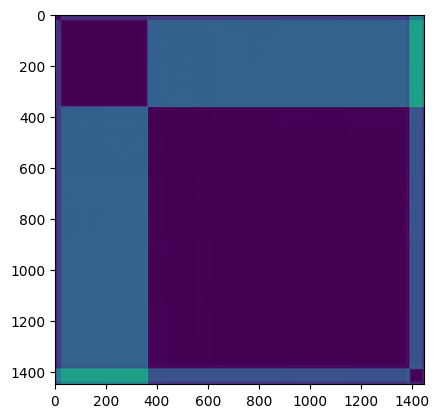

In [11]:
from scipy.stats import kendalltau
dist_mat = np.zeros((len(trip_arrays),len(trip_arrays)))
for i,t1 in enumerate(trip_arrays):
    for j,t2 in enumerate(trip_arrays[i+1:]):
        dist_mat[i,i+j+1] = abs(t1[:,0].max() - t2[:,0].max())
#         dist_mat[i,i+j+1] = kendalltau(t1[:,0],t2[:,0])[1] + kendalltau(t1[:,1],t2[:,1])[1]
#         dist_mat[i,i+j+1] = (1-kendalltau(t1[:,0],t2[:,0])[0]) * (1-kendalltau(t1[:,1],t2[:,1])[0])
#         x = ((t - np.mean(t,axis=0))*(t2 - np.mean(t2,axis=0))).sum(0)
#         y,z = np.linalg.norm((t - np.mean(t,axis=0)), axis=0),np.linalg.norm((t2 - np.mean(t2,axis=0)), axis=0)
#         dist_mat[i,i+j+1] = 1-x[0]*x[1]/(y[0]*y[1]*z[0]*z[1])
dist_mat += dist_mat.T
# .square( trip_arrays[:,None] - trip_arrays[None]).sum(-1).max(-1)**0.5
ag, lmat = autocluster(dist_mat, return_order=True, plot=True, affinity="precomputed", linkage='average')
order = lmat#['leaves']
plt.imshow(dist_mat[order][:,order])
plt.show()

In [12]:
correct_cluster = np.argmax([sum(ag.labels_==i) for i in range(ag.n_clusters)])
print("correct cluster is ", correct_cluster)
valid_arts = [ a for i,a in enumerate(all_arts) if ag.labels_[i]==correct_cluster]
print(len(valid_arts))

correct cluster is  1
940


In [13]:
# filter by how close they are to real stops
real_artstop_locations = [ stoplocations[s] for s,v in stopnames.items() if 'ART' in v]
real_artstop_locations

[{'lat': 35.070248, 'lng': -106.51563300000001},
 {'lat': 35.072183, 'lng': -106.533424},
 {'lat': 35.074090000000005, 'lng': -106.55088799999999},
 {'lat': 35.066138, 'lng': -106.498065},
 {'lat': 35.073714, 'lng': -106.549733},
 {'lat': 35.071742, 'lng': -106.531578},
 {'lat': 35.069891, 'lng': -106.514582},
 {'lat': 35.080046, 'lng': -106.710101},
 {'lat': 35.082701, 'lng': -106.69833100000001},
 {'lat': 35.085698, 'lng': -106.685129},
 {'lat': 35.094381, 'lng': -106.669974},
 {'lat': 35.089636999999996, 'lng': -106.66428700000002},
 {'lat': 35.083228000000005, 'lng': -106.641049},
 {'lat': 35.082217, 'lng': -106.633021},
 {'lat': 35.081338, 'lng': -106.626478},
 {'lat': 35.081053000000004, 'lng': -106.62011799999999},
 {'lat': 35.0805, 'lng': -106.609602},
 {'lat': 35.078859, 'lng': -106.595652},
 {'lat': 35.077876, 'lng': -106.586646},
 {'lat': 35.075996, 'lng': -106.56932900000001},
 {'lat': 35.080003000000005, 'lng': -106.71013899999998},
 {'lat': 35.082669, 'lng': -106.698365},

In [14]:
## I could also just identify the spots where it stops
art_stops = []
speed_limit = 5
stupid_trips = []
for idx, art in enumerate(tqdm(valid_arts)):
#     art = df[df.trip_id == artid]
    art = art.iloc[np.argsort(art.msg_time)]
    prev_speed = 100
    lat = 0
    lng = 0
    stop_start = -1
    duration = 0
    for _,row in art.iterrows():
        eastbound = art.iloc[0].longitude < art.iloc[-1].longitude
        if row.speed_mph < speed_limit and 100 < min([geopy.distance.geodesic((row.latitude,row.longitude), (b['lat'], b['lng'])).feet for b in real_artstop_locations]):
#             if prev_speed < speed_limit:
                duration_delta = str2time(row.msg_time) - stop_start
                duration += duration_delta
                lat += duration_delta * row.latitude
                lng += duration_delta * row.longitude
#                 stop_start = str2time(row.msg_time)
#                 continue
#             elif duration > 0:
#                 stop_start = str2time(row.msg_time)
#                 stop_location = (lat / duration, lng/duration)
                
# #                 prev_speed = 0
                
#                 duration = 0
#                 lat = 0
#                 lng = 0
        else:
            if duration > 0:
                art_stops.append(((lat / duration, lng/duration), duration, idx, eastbound))
                if duration > 40000:
                    stupid_trips.append((arts, art_stops[-1]))
                lat = 0
                lng = 0
                duration = 0
                
                
        stop_start = str2time(row.msg_time)
        prev_speed = row.speed_mph

100%|████████████████████████████████████████████████████████████████████████████████| 940/940 [09:43<00:00,  1.61it/s]


In [15]:
# art_stops = [ dict(lat=a[0][0], lng=a[0][1], duration=a[1], dist_to_station=min(geopy.distance.geodesic())]
art_stop_info = []
for a in tqdm(art_stops):
    lat = a[0][0]
    lng = a[0][1]
    duration = a[1]
    
    dist_to_station = min([geopy.distance.geodesic((lat,lng), (b['lat'], b['lng'])).feet for b in real_artstop_locations])
    art_stop_info.append(dict(lat=lat, lng=lng, duration=duration, dist_to_station=dist_to_station, id=a[2], eastbound=a[3]))

far_stops = [ a for a in art_stop_info if a['dist_to_station'] > 100 ]
len(far_stops)

100%|███████████████████████████████████████████████████████████████████████████| 16285/16285 [01:08<00:00, 238.29it/s]


16280

In [16]:
far_stops_euclid = [ ll2euclid(d['lat'], d['lng'])  for d in far_stops]
ag = autocluster(far_stops_euclid)

number of clusters:  63


In [17]:
# ag = AgglomerativeClustering(n_clusters=None, distance_threshold=300, linkage='complete')
# ag.fit([ ll2euclid(d['lat'], d['lng']) for d in far_stops])

In [18]:
# now find cluster centers and count total delay
cluster_groups = [[] for _ in range(ag.n_clusters_)]
cluster_groups_eb = [[] for _ in range(ag.n_clusters_)]
cluster_groups_wb = [[] for _ in range(ag.n_clusters_)]
for i,stop in enumerate(tqdm(far_stops)):
    cluster_groups[ag.labels_[i]].append(stop)
    if stop['eastbound']:
        cluster_groups_eb[ag.labels_[i]].append(stop)
    else:
        cluster_groups_wb[ag.labels_[i]].append(stop)

max_radius = 300
clusters = []
for i,gp in enumerate(tqdm(cluster_groups)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))
    

max_radius = 300
clusters_eb = []
for i,gp in enumerate(tqdm(cluster_groups_eb)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters_eb.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))
    

max_radius = 300
clusters_wb = []
for i,gp in enumerate(tqdm(cluster_groups_wb)):
    lat = np.mean([g['lat'] for g in gp])
    lng = np.mean([g['lng'] for g in gp])
    rads = [ np.linalg.norm(ll2euclid(lat, lng) - ll2euclid(g['lat'], g['lng'])) for g in gp]
    lat = np.mean([g['lat'] for g,r in zip(gp, rads) if r < max_radius])
    lng = np.mean([g['lng'] for g,r in zip(gp, rads) if r < max_radius])
    duration = sum([g['duration'] for g,r in zip(gp, rads) if r < max_radius])
    durations = [g['duration'] for g,r in zip(gp, rads) if r < max_radius]
    
#     radius = max([r for g,r in zip(gp, rads) if r < max_radius])
    counts = len(set([g['id'] for g,r in zip(gp, rads) if r < max_radius]))
    clusters_wb.append( dict(lat=lat, lng=lng, duration=duration, counts=counts, durations=durations))#, radius=radius))

  0%|                                                                                           | 0/63 [00:00<?, ?it/s]C:\Users\patri\anaconda3\envs\jupyter\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\patri\anaconda3\envs\jupyter\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 533.53it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 678.64it/s]


loading image


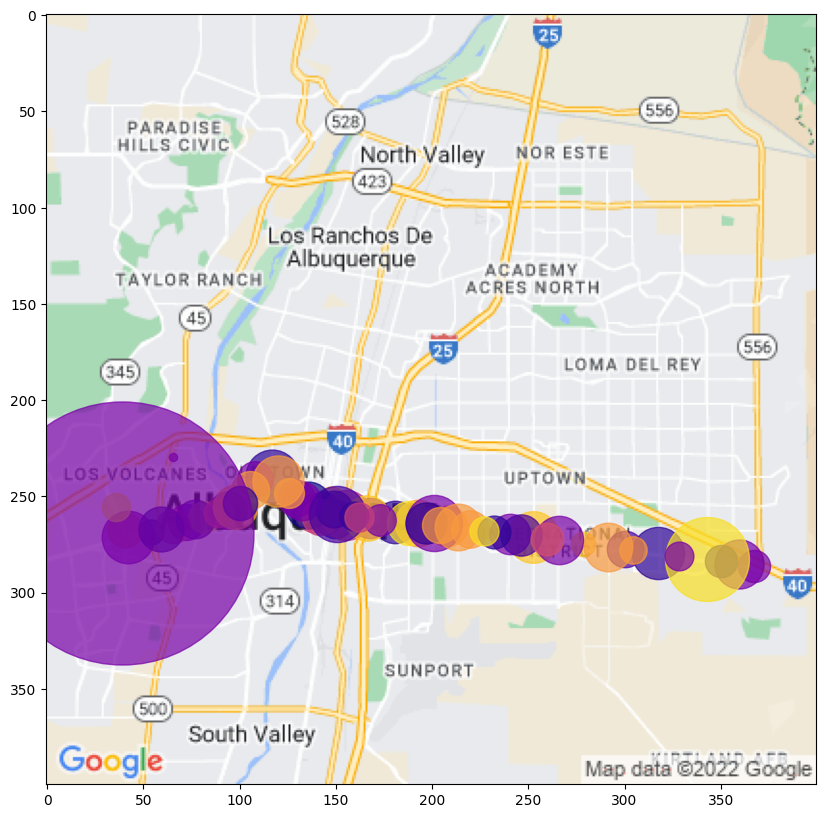

In [19]:
for i,cluster in enumerate(tqdm(clusters)):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(cluster['duration']))


In [20]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ', cluster['duration']/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
    print()


Cluster  1
	Lat/lon:  35.07879289 ,  -106.72528859
	Total delay:  214563.33333333334 min
	Number of stops:  360
	Average delay:  596.0092592592592 min
		25%ile: 3.938
		50%ile: 597.933
		75%ile: 875.975

Cluster  2
	Lat/lon:  35.07013114 ,  -106.51496456
	Total delay:  2219.6666666666665 min
	Number of stops:  281
	Average delay:  7.899169632265718 min
		25%ile: 0.667
		50%ile: 0.8
		75%ile: 1.067

Cluster  3
	Lat/lon:  35.08401098 ,  -106.64789467
	Total delay:  447.43333333333334 min
	Number of stops:  719
	Average delay:  0.6222994900324524 min
		25%ile: 0.4
		50%ile: 0.533
		75%ile: 0.8

Cluster  4
	Lat/lon:  35.08097309 ,  -106.61321271
	Total delay:  445.8333333333333 min
	Number of stops:  522
	Average delay:  0.8540868454661558 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 1.067

Cluster  5
	Lat/lon:  35.09509457 ,  -106.671448
	Total delay:  351.0833333333333 min
	Number of stops:  508
	Average delay:  0.6911089238845144 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.933

Clust

In [ ]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -np.median(x['durations'])*len(x['durations']))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ', np.median(cluster['durations'])*len(cluster['durations'])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
    print()


In [103]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


Cluster  1
	Lat/lon:  35.07879289 ,  -106.72528859
	Total delay:  553.8666666666667 min
	Number of stops:  360
	Average delay:  596.0092592592592 min
		25%ile: 3.938
		50%ile: 597.933
		75%ile: 875.975

Cluster  2
	Lat/lon:  35.08401098 ,  -106.64789467
	Total delay:  447.43333333333334 min
	Number of stops:  719
	Average delay:  0.6222994900324524 min
		25%ile: 0.4
		50%ile: 0.533
		75%ile: 0.8

Cluster  3
	Lat/lon:  35.08097309 ,  -106.61321271
	Total delay:  445.8333333333333 min
	Number of stops:  522
	Average delay:  0.8540868454661558 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 1.067

Cluster  4
	Lat/lon:  35.09509457 ,  -106.671448
	Total delay:  351.0833333333333 min
	Number of stops:  508
	Average delay:  0.6911089238845144 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.933

Cluster  5
	Lat/lon:  35.07735301 ,  -106.722952
	Total delay:  342.8 min
	Number of stops:  385
	Average delay:  0.8903896103896104 min
		25%ile: 0.4
		50%ile: 0.8
		75%ile: 1.2

Cluster  6
	Lat/lon:  35

In [152]:
print('Eastbound')
total_delay = 0
for i,cluster in enumerate(sorted(clusters_eb, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    if cluster['counts'] == 0:
        continue
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()
    if cluster['lng'] > -106.7218602:
        total_delay += sum([d for d in cluster['durations'] if d < 10000])/60
n_eastbound = 0
for idx, art in enumerate(tqdm(valid_arts)):
#     art = df[df.trip_id == artid]
    art = art.iloc[np.argsort(art.msg_time)]
    eastbound = art.iloc[0].longitude < art.iloc[-1].longitude
    if eastbound:
        n_eastbound +=1
print("Total delay: ", total_delay)
print("Average delay: ", total_delay / n_eastbound)

Eastbound
Cluster  1
	Lat/lon:  35.07880692 ,  -106.72528667
	Total delay:  363.8333333333333 min
	Number of stops:  317
	Average delay:  676.2564668769716 min
		25%ile: 402.362
		50%ile: 657.3
		75%ile: 915.3

Cluster  2
	Lat/lon:  35.07737316 ,  -106.72307097
	Total delay:  290.8 min
	Number of stops:  307
	Average delay:  0.9472312703583062 min
		25%ile: 0.533
		50%ile: 0.933
		75%ile: 1.2

Cluster  3
	Lat/lon:  35.07976773 ,  -106.71113182
	Total delay:  179.2 min
	Number of stops:  220
	Average delay:  0.8145454545454546 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 1.067

Cluster  4
	Lat/lon:  35.09522433 ,  -106.67178598
	Total delay:  173.48333333333332 min
	Number of stops:  227
	Average delay:  0.7642437591776798 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.933

Cluster  5
	Lat/lon:  35.08391809 ,  -106.64805429
	Total delay:  165.31666666666666 min
	Number of stops:  280
	Average delay:  0.5904166666666667 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.8

Cluster  6
	Lat/l

100%|██████████████████████| 940/940 [00:00<00:00, 1992.69it/s]

Total delay:  3145.35
Average delay:  6.974168514412416


In [151]:
print('Westbound')
total_delay = 0
for i,cluster in enumerate(sorted(clusters_wb, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))):
    if cluster['counts'] == 0:
        continue
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()
    if cluster['lng'] > -106.7218602:
        total_delay += sum([d for d in cluster['durations'] if d < 10000])/60
n_westbound = 0
for idx, art in enumerate(tqdm(valid_arts)):
#     art = df[df.trip_id == artid]
    art = art.iloc[np.argsort(art.msg_time)]
    eastbound = art.iloc[0].longitude < art.iloc[-1].longitude
    if not eastbound:
        n_westbound +=1
print("Total delay: ", total_delay)
print("Average delay: ", total_delay / n_westbound)

Westbound
Cluster  1
	Lat/lon:  35.08093647 ,  -106.61295043
	Total delay:  309.85 min
	Number of stops:  307
	Average delay:  1.0092833876221499 min
		25%ile: 0.446
		50%ile: 0.8
		75%ile: 1.2

Cluster  2
	Lat/lon:  35.08407072 ,  -106.64779202
	Total delay:  282.1166666666667 min
	Number of stops:  439
	Average delay:  0.6426347760060744 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 0.8

Cluster  3
	Lat/lon:  35.075844 ,  -106.56816357
	Total delay:  244.88333333333333 min
	Number of stops:  345
	Average delay:  0.7098067632850241 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 0.933

Cluster  4
	Lat/lon:  35.06857928 ,  -106.5034451
	Total delay:  239.1 min
	Number of stops:  377
	Average delay:  0.6342175066312997 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.8

Cluster  5
	Lat/lon:  35.07013948 ,  -106.51492121
	Total delay:  228.6 min
	Number of stops:  257
	Average delay:  8.590012970168612 min
		25%ile: 0.667
		50%ile: 0.933
		75%ile: 1.067

Cluster  6
	Lat/lon:  35.07201456 ,  -10

100%|██████████████████████| 940/940 [00:00<00:00, 1977.74it/s]

Total delay:  4409.283333333332
Average delay:  9.016939331970004


loading image


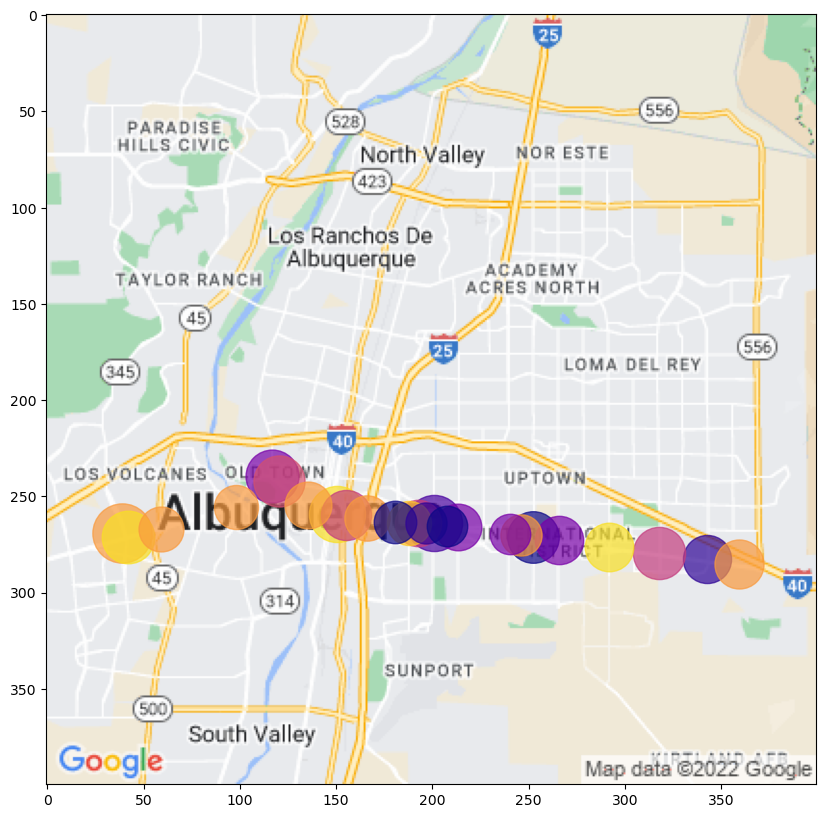

In [104]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['duration'])[:25]):
    plot_abq([(cluster['lat'], cluster['lng'])], first=i==0, c=cm.plasma((ag.labels_[i] **2 % 17)/17), alpha=0.7, s=10*np.sqrt(sum([d for d in cluster['durations'] if d < 10000])))


In [106]:
(sum([ sum([d for d in cluster['durations'] if d < 10000])/60  for i,cluster in enumerate(clusters) if i not in [0,9]]) ) / (940)

8.713829787234042

In [109]:
(sum([ sum([d for d in cluster['durations'] if d < 10000])/60  for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000]))) if i not in [0,9]]) ) / (940)

8.230035460992909

In [68]:
(sum([d for x in clusters for d in x['durations'] if d < 10000])) / (60*940)

9.480585106382978

In [46]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] ])) / (60*940)

235.23810283687942

In [49]:
(sum([ (c['duration'])  for c in clusters if c['duration'] < 4000*60 and c['counts'] != 407]) ) / (60*940)

10.821950354609928

In [48]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] if c['duration'] < 4000*60 and c['counts'] != 407])) / (60*940)

6.804468085106383

In [50]:
(sum([ c['duration'] for c in sorted(clusters, key=lambda x: -x['duration'] )[:25] if c['duration'] < 2000*60 and c['counts'] != 407])) / (60*940)

4.449326241134751

In [52]:
jt = sorted(clusters, key=lambda x: -x['duration'] )[1]
jt['duration']

132830

In [110]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -x['counts'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', cluster['duration'] / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


Cluster  1
	Lat/lon:  35.08401098 ,  -106.64789467
	Total delay:  447.43333333333334 min
	Number of stops:  719
	Average delay:  0.6222994900324524 min
		25%ile: 0.4
		50%ile: 0.533
		75%ile: 0.8

Cluster  2
	Lat/lon:  35.09362784 ,  -106.66898842
	Total delay:  306.35 min
	Number of stops:  627
	Average delay:  0.4885964912280702 min
		25%ile: 0.267
		50%ile: 0.4
		75%ile: 0.667

Cluster  3
	Lat/lon:  35.08097309 ,  -106.61321271
	Total delay:  445.8333333333333 min
	Number of stops:  522
	Average delay:  0.8540868454661558 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 1.067

Cluster  4
	Lat/lon:  35.08367146 ,  -106.64467232
	Total delay:  282.0833333333333 min
	Number of stops:  511
	Average delay:  0.5520221787345075 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.667

Cluster  5
	Lat/lon:  35.09509457 ,  -106.671448
	Total delay:  351.0833333333333 min
	Number of stops:  508
	Average delay:  0.6911089238845144 min
		25%ile: 0.267
		50%ile: 0.533
		75%ile: 0.933

Cluster  6
	Lat/lon:

In [112]:
for i,cluster in enumerate(sorted(clusters, key=lambda x: -sum([d for d in x['durations'] if d < 10000])/x['counts'])):
    print('Cluster ', i+1)
    print('\tLat/lon: ', round(cluster['lat'],8), ', ', round(cluster['lng'],8))
    print('\tTotal delay: ',sum([d for d in cluster['durations'] if d < 10000])/60, 'min')
    print('\tNumber of stops: ', cluster['counts'])
    print('\tAverage delay: ', sum([d for d in cluster['durations'] if d < 10000]) / (60 * cluster['counts']), 'min')
    print(f'\t\t25%ile: {round(np.quantile(cluster["durations"], 0.25)/60, 3)}')
    print(f'\t\t50%ile: {round(np.quantile(cluster["durations"], 0.5)/60, 3)}')
    print(f'\t\t75%ile: {round(np.quantile(cluster["durations"], 0.75)/60, 3)}')
#     print('\tRadius: ', max())
    print()


Cluster  1
	Lat/lon:  35.07879289 ,  -106.72528859
	Total delay:  553.8666666666667 min
	Number of stops:  360
	Average delay:  1.5385185185185186 min
		25%ile: 3.938
		50%ile: 597.933
		75%ile: 875.975

Cluster  2
	Lat/lon:  35.08638849 ,  -106.72747994
	Total delay:  27.933333333333334 min
	Number of stops:  31
	Average delay:  0.9010752688172043 min
		25%ile: 0.533
		50%ile: 0.8
		75%ile: 1.067

Cluster  3
	Lat/lon:  35.07735301 ,  -106.722952
	Total delay:  342.8 min
	Number of stops:  385
	Average delay:  0.8903896103896104 min
		25%ile: 0.4
		50%ile: 0.8
		75%ile: 1.2

Cluster  4
	Lat/lon:  35.07013114 ,  -106.51496456
	Total delay:  240.63333333333333 min
	Number of stops:  281
	Average delay:  0.8563463819691578 min
		25%ile: 0.667
		50%ile: 0.8
		75%ile: 1.067

Cluster  5
	Lat/lon:  35.08097309 ,  -106.61321271
	Total delay:  445.8333333333333 min
	Number of stops:  522
	Average delay:  0.8540868454661558 min
		25%ile: 0.4
		50%ile: 0.667
		75%ile: 1.067

Cluster  6
	Lat/lon: 

In [55]:
print(np.median(jt['durations']))
print(np.mean(jt['durations']))

50.0
476.0931899641577


(array([277.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([7.00000e+00, 6.83380e+03, 1.36606e+04, 2.04874e+04, 2.73142e+04,
        3.41410e+04, 4.09678e+04, 4.77946e+04, 5.46214e+04, 6.14482e+04,
        6.82750e+04]),
 <BarContainer object of 10 artists>)

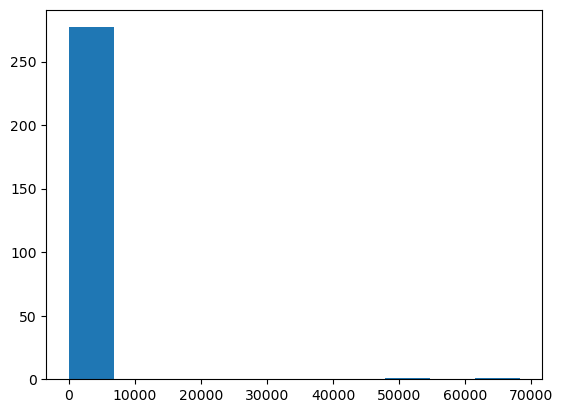

In [60]:
plt.hist(jt['durations'])

# Auxiliary stuff

(array([  4.,  28., 220., 420., 234.,  31.,   2.,   0.,   0.,   1.]),
 array([ 708. , 1491.3, 2274.6, 3057.9, 3841.2, 4624.5, 5407.8, 6191.1,
        6974.4, 7757.7, 8541. ]),
 <BarContainer object of 10 artists>)

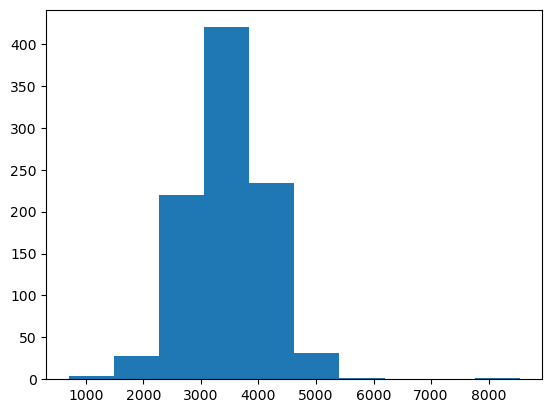

In [40]:
trip_durations = []
for art in valid_arts:
    msg_times = [str2time(t) for t in art.msg_time]
    trip_durations.append( max(msg_times) - min(msg_times))
plt.hist(trip_durations)

In [41]:
np.median(trip_durations)

3640.0

In [120]:
[s for s in stopnames.values() if 'ART' in s]

['Central @ Juan Tabo  (ART)',
 'Central @ Eubank  (ART)',
 'Central @ Wyoming (ART)',
 'Tramway @ Wenonah (ART)',
 'Central @ Wyoming (ART)',
 'Central @ Eubank (ART)',
 'Central @ Juan Tabo (ART)',
 'ART - West Central Station',
 'ART - The Bluffs Station',
 'ART - Town of Atrisco Station',
 'ART - Old Town Station',
 'ART - West Downtown Station',
 'ART - EDo Station',
 'ART - Presbyterian Station',
 'ART - UNM / CNM Station',
 'ART - UNM Popejoy Station',
 'ART - Nob Hill Station',
 'ART - Highland Station',
 'ART - San Mateo Station',
 'ART - International District Station',
 'ART - West Central Station',
 'ART - The Bluffs Station',
 'ART - Town of Atrisco Station',
 'ART - Old Town Station',
 'ART - West Downtown Station',
 'ART - EDo Station',
 'ART - Presbyterian Station',
 'ART - UNM / CNM Station',
 'ART - UNM Popejoy Station',
 'ART - Highland Station',
 'ART - San Mateo Station',
 'ART - International District Station',
 'ART - BioPark Station',
 'ART - BioPark Station',
 

In [123]:
set(art[art.next_stop_name=='ART - Nob Hill East Station'].next_stop_sched_time)

{'17:06:29'}

In [125]:
set(art[art.next_stop_name=='ART - UNM / CNM Station'].next_stop_sched_time)

{'17:13:17'}

In [127]:
(str2time('17:13:17') - str2time('17:06:29'))/60

6.8

In [143]:
df

,Unnamed: 0,vehicle_id,msg_time,latitude,longitude,heading,speed_mph,route_short_name,trip_id,next_stop_id,next_stop_name,next_stop_sched_time,access_time
0,0,601,18:27:27,35.089300,-106.733040,90,0,Off Duty,0,0,No Data,18:27:27,2022-09-18 03:04:56.039943
1,1,606,18:27:13,35.089420,-106.732860,88,0,Off Duty,0,0,No Data,18:27:13,2022-09-18 03:04:56.040943
2,2,607,18:36:11,35.089390,-106.733220,78,0,Off Duty,0,0,No Data,18:36:11,2022-09-18 03:04:56.040943
3,3,608,19:34:11,35.089310,-106.733550,290,0,Off Duty,Undetermined,Undetermined,Depot,19:06:00,2022-09-18 03:04:56.040943
4,4,613,02:19:32,35.089350,-106.733800,168,0,Off Duty,Undetermined,Undetermined,Depot,23:40:00,2022-09-18 03:04:56.041943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444556,2444556,1521,22:27:46,35.089780,-106.733320,306,0,Off Duty,0,0,No Data,22:27:46,2022-09-19 03:00:12.843113
2444557,2444557,754,17:50:11,35.088731,-106.734191,288,0,Off Duty,0,0,No Data,17:50:11,2022-09-19 03:00:12.844113
2444558,2444558,954,17:49:12,35.088816,-106.734100,162,7,Off Duty,0,0,No Data,17:49:12,2022-09-19 03:00:12.844113
2444559,2444559,609,14:43:26,35.088500,-106.734170,196,0,Off Duty,0,0,No Data,14:43:26,2022-09-19 03:00:12.844113
